# Satellite Imagery

In this section we turn to **raster** data, specifically, to satellite imagery.  

In [1]:
import ibis
from ibis import _
con = ibis.duckdb.connect()

city = (con
        .read_geo("/vsicurl/https://dsl.richmond.edu/panorama/redlining/static/mappinginequality.gpkg")
        .filter(_.city == "New Haven")
        .execute()
       )
box = city.total_bounds
box

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

array([-72.99321,  41.23109, -72.85227,  41.37502])

In [2]:
from pystac_client import Client
import odc.stac
import pystac_client
import rioxarray
import geopandas as gpd
from rasterstats import zonal_stats 
import dask


In [3]:
items = (
  Client.
  open("https://earth-search.aws.element84.com/v1").
  search(
    collections = ['sentinel-2-l2a'],
    bbox = box,
    datetime = "2024-06-01/2024-08-01",
    query={"eo:cloud_cover": {"lt": 20}}).
  item_collection()
)

In [4]:
items

In [5]:
data = odc.stac.load(
    items,
    bands=["nir08", "red"],
    bbox=box,
    chunks = {}
)

In [6]:
ndvi = (
    ((data.nir08 - data.red) / (data.red + data.nir08))
    .median("time", keep_attrs=True)
)

ndvi = ndvi.where(ndvi < 1)




In [7]:
ndvi

<xarray.DataArray (y: 1627, x: 1220)> Size: 16MB
dask.array<where, shape=(1627, 1220), dtype=float64, chunksize=(1627, 1220), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 13kB 4.583e+06 4.583e+06 ... 4.566e+06 4.566e+06
  * x            (x) float64 10kB 6.678e+05 6.678e+05 ... 6.8e+05 6.8e+05
    spatial_ref  int32 4B 32618

In [8]:
ndvi.rio.to_raster("ndvi.tif", driver = "COG")

/opt/conda/lib/python3.11/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


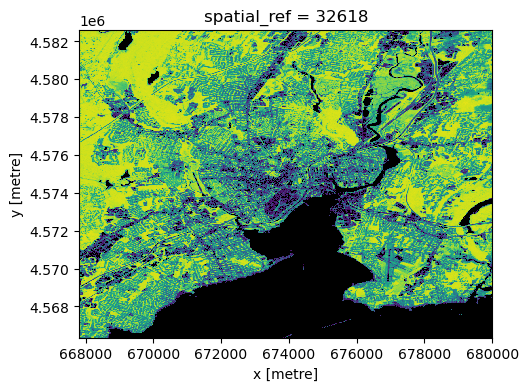

In [9]:
import matplotlib as plt
cmap = plt.colormaps.get_cmap('viridis')  # viridis is the default colormap for imshow
cmap.set_bad(color='black')

ndvi.plot.imshow( cmap=cmap, add_colorbar=False, size=4)

In [ ]:
import leafmap.maplibregl as leafmap
m = leafmap.Map()
m.add_gdf(city)
m.add_raster("ndvi.tif")
#m